In [10]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
import time
from functools import reduce
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
from six.moves import cPickle as pickle
from six.moves import range

%matplotlib inline

import tensorflow as tf

In [11]:
files = [
    'data_batch_1',
    'data_batch_2',
    'data_batch_3',
    'data_batch_4',
    'data_batch_5',
    'test_batch'
]

data = []
labels = []
start = time.time()
for file in files:
    with open(file, 'rb') as f:
        d = pickle.load(f, encoding='bytes')
        if file == 'test_batch':
            test_data = d[b'data']
            test_labels = d[b'labels']
        else:
            data.append(d[b'data'])
            labels.append(d[b'labels'])
end = time.time()
print('Time to load data: {:.3f}s'.format(end - start))
for i in range(len(data)):
    print('Train data {}:'.format(i), data[i].shape, len(labels[i]))
print('Test data:', test_data.shape, len(test_labels))

merged_data = reduce(lambda a,b: np.vstack((a,b)), data)
merged_labels = reduce(lambda a,b: a+b, labels)
print('Merged train data:', merged_data.shape, len(merged_labels))

Time to load data: 0.138s
Train data 0: (10000, 3072) 10000
Train data 1: (10000, 3072) 10000
Train data 2: (10000, 3072) 10000
Train data 3: (10000, 3072) 10000
Train data 4: (10000, 3072) 10000
Test data: (10000, 3072) 10000
Merged train data: (50000, 3072) 50000


In [ ]:
def parse_images(data, img_size, num_channels):
    print(data.shape)
    rows, cols = data.shape
    assert(cols == img_size * img_size * num_channels)
    for i in range(rows):
        row = data[i,:]
        
    

In [19]:
img_size = 32
num_labels = 10
merged_labels_np = np.array(merged_labels)
test_labels_np = np.array(test_labels)

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, img_size * img_size)).astype(np.float32)
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels


def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0])


train_dataset, train_labels = reformat(merged_data, merged_labels_np)
test_dataset, test_labels_np = reformat(test_data, test_labels_np)
print('Training set', train_dataset.shape, train_labels.shape)
print('Test set', test_dataset.shape, test_labels_np.shape)

Training set (150000, 1024) (50000, 10)
Test set (30000, 1024) (10000, 10)


In [44]:
batch_size = 256

graph = tf.Graph()
with graph.as_default():

    # Input data, with a placeholder to feed the training data at run time.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, img_size*img_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights = tf.Variable(tf.truncated_normal([img_size*img_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [48]:
num_epochs = 3001
l_array = []

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    merged = tf.merge_all_summaries()  
    writer = tf.train.SummaryWriter("/tmp/tensorflowlogs", session.graph)
    print("Initialized")
    for epoch in range(num_epochs):
        
        offset = (epoch * batch_size) % (train_labels.shape[0] - batch_size)

        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]

        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        l_array.append(l)
        if (epoch % 500 == 0):
            print("Minibatch loss at epoch %d: %f" % (epoch, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels_np))
    test_preds = pd.DataFrame(test_prediction.eval().ravel(), columns=['LR_SGD'])

Initialized
Minibatch loss at epoch 0: 5249.584961
Minibatch accuracy: 12.9%
Minibatch loss at epoch 500: 2142477.000000
Minibatch accuracy: 11.7%
Minibatch loss at epoch 1000: 2417778.500000
Minibatch accuracy: 8.2%
Minibatch loss at epoch 1500: 2090072.625000
Minibatch accuracy: 9.0%
Minibatch loss at epoch 2000: 3465984.000000
Minibatch accuracy: 8.6%
Minibatch loss at epoch 2500: 3423298.750000
Minibatch accuracy: 9.0%
Minibatch loss at epoch 3000: 2628802.000000
Minibatch accuracy: 12.1%
Test accuracy: 0.0%


/Users/cindy.liu/Desktop/cindy/e81/e81-venv/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


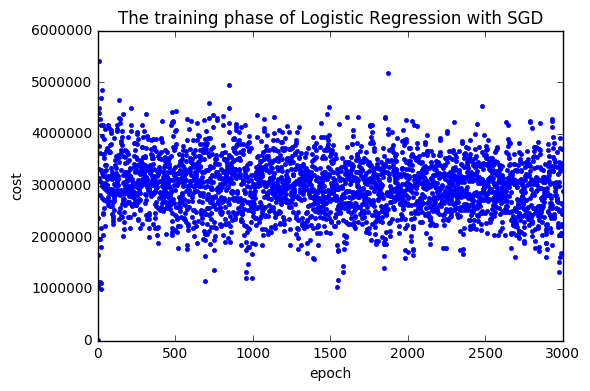

In [49]:
plt.plot(range(num_epochs), l_array, '.')
plt.xlabel("epoch")
plt.ylabel("cost")
plt.title("The training phase of Logistic Regression with SGD")
plt.show()

In [13]:
def weight_variable(shape):
    #initial = tf.truncated_normal(shape, stddev=0.01)
    initial = tf.truncated_normal(shape, stddev=tf.sqrt(2.0/shape[0]))
    return tf.Variable(initial)

def bias_variable(shape):
    #initial = tf.constant(0.1, shape=shape)
    initial = tf.zeros(shape)
    return tf.Variable(initial)

split_by_half = lambda x,k : int(x/2**k)

In [15]:
batch_size = 256
hidden_nodes = 1024
lamb_reg = 0.001

graph = tf.Graph()
with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, img_size*img_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    layer1_weights = weight_variable([img_size*img_size, hidden_nodes])
    layer1_biases = bias_variable([hidden_nodes])
    layer2_weights = weight_variable([hidden_nodes, split_by_half(hidden_nodes,1)])
    layer2_biases = bias_variable([split_by_half(hidden_nodes,1)])   
    layer3_weights = weight_variable([split_by_half(hidden_nodes,1), split_by_half(hidden_nodes,2)])
    layer3_biases = bias_variable([split_by_half(hidden_nodes,2)])    
    layer4_weights = weight_variable([split_by_half(hidden_nodes,2), num_labels])
    layer4_biases = bias_variable([num_labels])
    
    keep_prob = tf.placeholder("float")
    
    # Model with dropout
    def model(data, proba=keep_prob):
        layer1 = tf.matmul(data, layer1_weights) + layer1_biases
        hidden1 = tf.nn.dropout(tf.nn.relu(layer1), proba)  # dropout on hidden layer
        layer2 = tf.matmul(hidden1, layer2_weights) + layer2_biases  # a new hidden layer
        hidden2 = tf.nn.dropout(tf.nn.relu(layer2), proba)
        layer3 = tf.matmul(hidden2, layer3_weights) + layer3_biases
        hidden3 = tf.nn.dropout(tf.nn.relu(layer3), proba)
        return tf.matmul(hidden3, layer4_weights) + layer4_biases
    
    # Training computation.
    logits = model(tf_train_dataset, keep_prob)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    regularizers = (tf.nn.l2_loss(layer1_weights) + tf.nn.l2_loss(layer1_biases) + \
                    tf.nn.l2_loss(layer2_weights) + tf.nn.l2_loss(layer2_biases) + \
                    tf.nn.l2_loss(layer3_weights) + tf.nn.l2_loss(layer3_biases) + \
                    tf.nn.l2_loss(layer4_weights) + tf.nn.l2_loss(layer4_biases) )

    # Add the regularization term to the loss.
    #loss += lamb_reg * regularizers
    loss = tf.reduce_mean(loss + lamb_reg * regularizers)

    # Optimizer.
    # learning rate decay
    global_step = tf.Variable(0)  # count number of steps taken.
    start_learning_rate = 0.5
    learning_rate = tf.train.exponential_decay(start_learning_rate, global_step, 100000, 0.96, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    test_prediction = tf.nn.softmax(model(tf_test_dataset,1.0))

In [22]:
# Re-define the function to include the keep probability
def run_session(num_epochs, name, k_prob=1.0):

    with tf.Session(graph=graph) as session:
        merged = tf.merge_all_summaries()  
        writer = tf.train.SummaryWriter("tensorflowlogs", session.graph)
        tf.initialize_all_variables().run()
        print("Initialized")
        for epoch in range(num_epochs):
            offset = (epoch * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob : k_prob}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (epoch % 500 == 0):
                print("Minibatch loss at epoch {}: {}".format(epoch, l))
                print("Minibatch accuracy: {:.1f}".format(accuracy(predictions, batch_labels)))
        print("Test accuracy: {:.1f}".format(accuracy(test_prediction.eval(), test_labels_np)))
        test_preds = pd.DataFrame(test_prediction.eval().ravel(), columns=['LR_SGD'])
        test_preds[name] = test_prediction.eval().ravel()

In [23]:
run_session(501, "Deep_NN", 0.5)

Initialized
Minibatch loss at epoch 0: 448.6424865722656
Minibatch accuracy: 7.8
Minibatch loss at epoch 500: nan
Minibatch accuracy: 9.8


/Users/cindy.liu/Desktop/cindy/e81/e81-venv/lib/python3.5/site-packages/ipykernel/__main__.py:14: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


Test accuracy: 0.0
